In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from data import wirtual
import random

In [2]:
wirtual_flat = [item for sublist in wirtual for item in sublist]
print(len(wirtual))

def rolling_avg(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        if i < window_size - 1:
            # For the first few elements, average the elements from the start to the current position
            rolling_avg[i] = np.mean(sequence[:i+1])
        else:
            # For the rest, compute the average of the window
            rolling_avg[i] = np.mean(sequence[i-window_size+1:i+1])
    return rolling_avg

def rolling_avg_both_sides(sequence, window_size):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-window_size//2+1
        end = start+window_size
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def rolling_avg_both_sides_asym(sequence, left, right):
    # Initialize the rolling average array
    rolling_avg = np.zeros_like(sequence, dtype=float)

    # Compute rolling average
    for i in range(len(sequence)):
        start = i-left
        end = i+right+1
        if start<0:
            start=0
        if end > len(sequence):
            end=len(sequence)
        rolling_avg[i] = np.mean(sequence[start:end])
    return rolling_avg

def remove_repeated_elements(arr):
    if not arr:
        return []
    result = [arr[0]]
    for el in arr:
        if el != result[-1]:
            result.append(el)
    return result

def exp_smoothing_average(sequence, alpha=0.05):
    avg = np.zeros_like(sequence, dtype=float)
    for i in range(1, len(sequence)):
        avg[i] = alpha*sequence[i] + (1-alpha)*(avg[i-1])
    return avg

def logistic_curve(n, low, high, shift, speed):
    return low + (high-low) / (1 + np.exp(-speed * (n-shift)))

def loss_logistic(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    loss = np.mean((sequence - predicted_probs)**2)
    return np.sum(loss)

def neg_log_likelihood(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    predicted_probs = np.clip(predicted_probs, 0.00000001, 0.99999999)
    loss = np.sum(-(sequence * np.log(predicted_probs) + (1-sequence) * np.log(1-predicted_probs)))
    return loss    

class Floor:
    
    def __init__(self):
        self.floor = None
        self.successes = None
        self.params = None
        self.rolling_avg = None
        self.fail_distribution = None
            
    @classmethod
    def from_data(cls, data, floor):
        obj = Floor()
        obj.floor = floor
        
        # Calculate successes and fail distribution
        obj.successes = []
        obj.fail_distribution = {i: 0 for i in range(floor+1)}
        for i in range(len(data)-1):
            if data[i] == floor:
                if data[i+1] == floor+1:
                    obj.successes.append(1)
                else:
                    obj.successes.append(0)
                    obj.fail_distribution[data[i+1]] += 1
        obj.successes = np.array(obj.successes)
                    
        # Compute rolling average
        window_size = 20
        obj.rolling_avg = rolling_avg(obj.successes, window_size)
        #obj.prob = rolling_avg_both_sides_asym(obj.successes, 40, 10)
        #obj.prob = exp_smoothing_average(obj.successes)
        
        # Train model
        initial_params = [0.0, 0.7, 0.9, 0.9]
        bounds = [(-10, 1), (0, 1), (-100, 300), (0, 30)]
        result = minimize(neg_log_likelihood, initial_params, args=(obj.successes,), bounds=bounds, method='L-BFGS-B')
        #result = minimize(loss_logistic, initial_params, args=(obj.prob,), method='L-BFGS-B')
        if result.success:
            obj.params = result.x
        else:
            print("Optimization failed:", result.message)
        return obj
            
    @classmethod
    def from_params(cls, floor, low, high, shift, speed):
        obj = Floor()
        obj.floor = floor
        obj.successes = list(range(100))
        obj.params = (low, high, shift, speed)
        obj.fail_distribution = {i:1 for i in range(floor)}
        return obj
            
    def simulate_one_step(self, attempt):
        p = logistic_curve(attempt, *self.params)
        if random.random() <= p:
            return self.floor + 1
        else:
            keys = list(self.fail_distribution.keys())
            weights = list(self.fail_distribution.values())
            sample = random.choices(keys, weights=weights, k=1)[0]
            return sample
            
    def plot(self):
        # Generate x values
        if self.rolling_avg is not None:
            x_values = np.arange(len(self.rolling_avg))
        else:
            x_values = np.arange(200)

        low, high, shift, speed = self.params

        # Calculate y values
        y_values = logistic_curve(x_values, low, high, shift, speed)

        # Plotting the result
        plt.figure(figsize=(10, 3))
        plt.plot(x_values, y_values, label='Logistic Curve')
        if self.rolling_avg is not None:
            plt.plot(x_values, self.rolling_avg, label="Rolling Average")
        plt.title(f'Floor {self.floor}')
        plt.xlabel('Attempts')
        plt.ylabel('Success Probability')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.show()

114


In [10]:
wirtual_flat = remove_repeated_elements(wirtual_flat)
wirtual_first_time_reached_floor = []
for i in range(18):
    try:
        wirtual_first_time_reached_floor.append(wirtual_flat.index(i))
    except:
        pass
wirtual_first_time_reached_floor

[0, 1, 20, 195, 257, 564, 612, 1112, 1772, 2116, 2366, 2655]

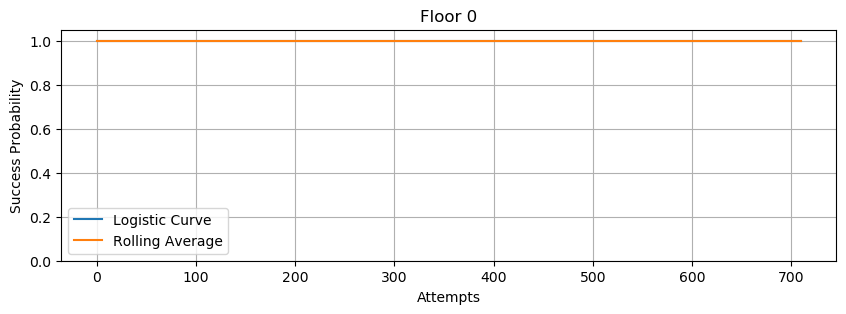

low=1.00, high=1.00, shift=-0.60, speed=1.28


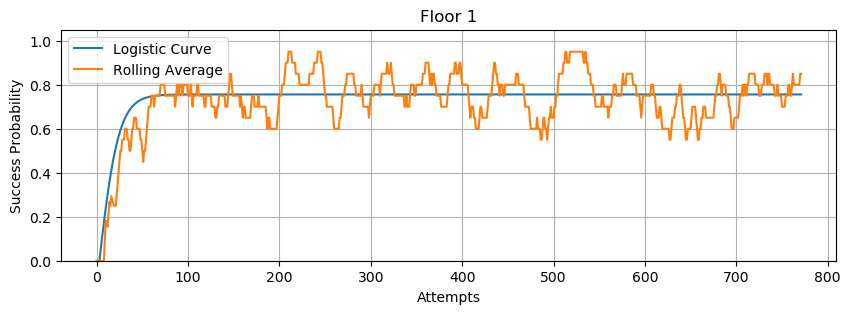

low=-0.90, high=0.76, shift=1.07, speed=0.09


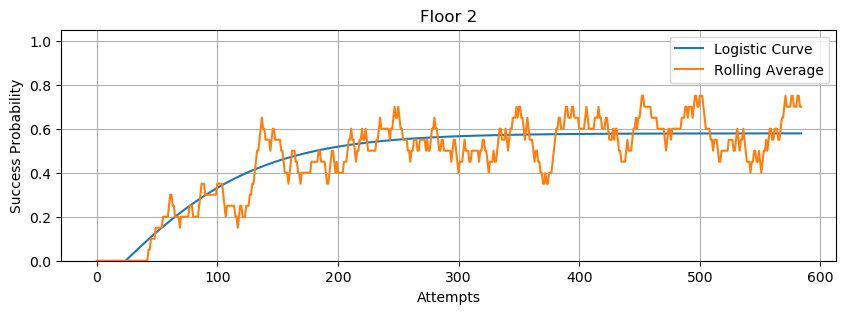

low=-0.83, high=0.58, shift=1.26, speed=0.02


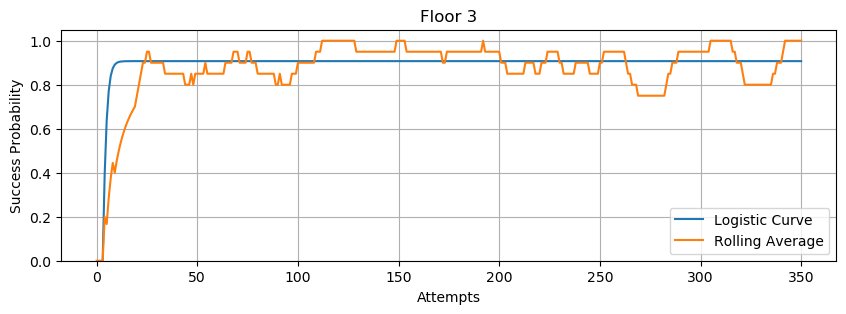

low=-2.36, high=0.91, shift=1.68, speed=0.73


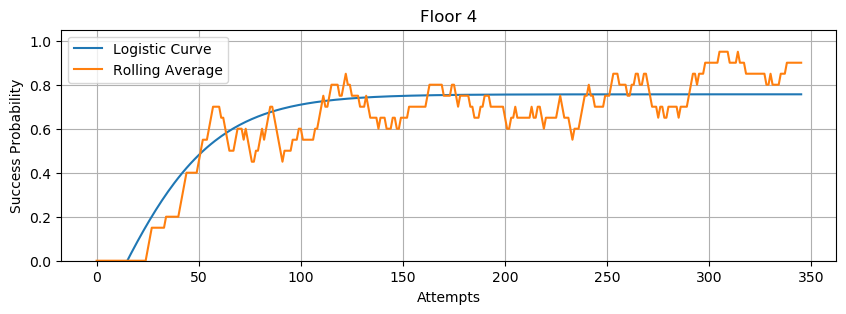

low=-1.27, high=0.76, shift=1.40, speed=0.04


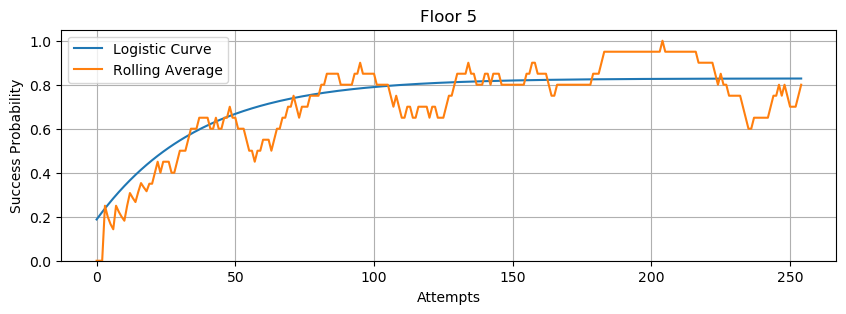

low=-10.00, high=0.83, shift=-96.91, speed=0.03


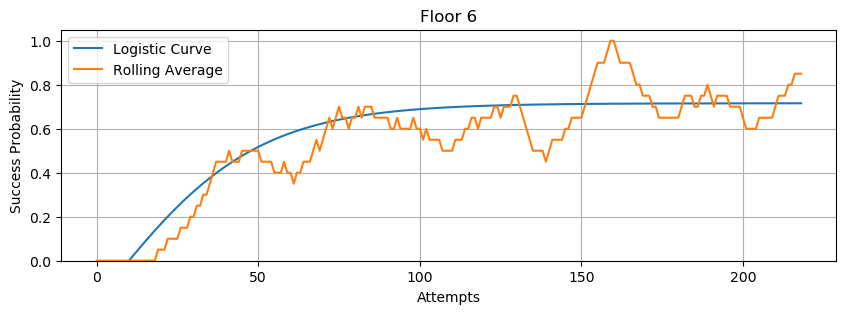

low=-1.03, high=0.72, shift=1.29, speed=0.04


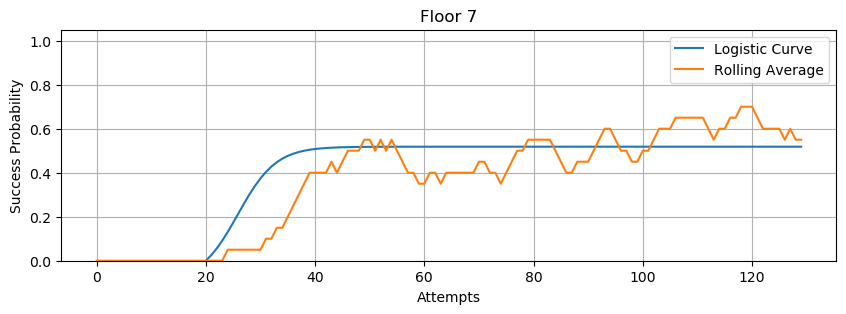

low=-0.10, high=0.52, shift=25.87, speed=0.29


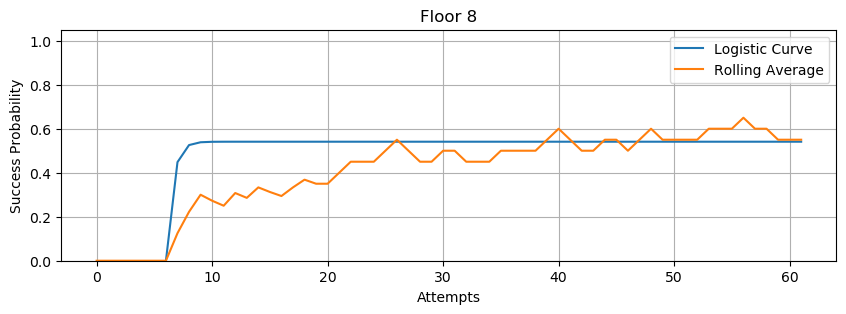

low=-8.53, high=0.54, shift=4.48, speed=1.81


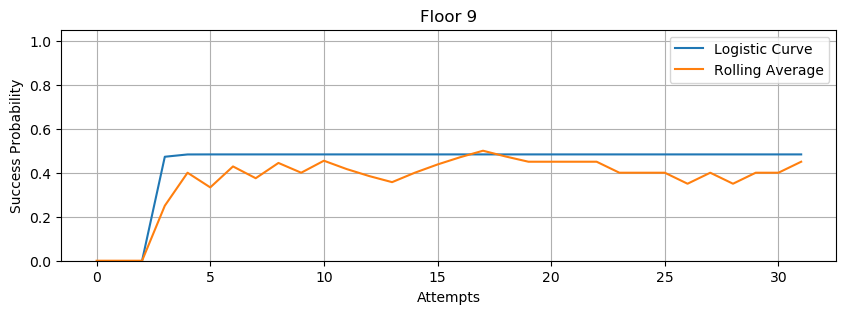

low=-2.81, high=0.48, shift=1.56, speed=3.97


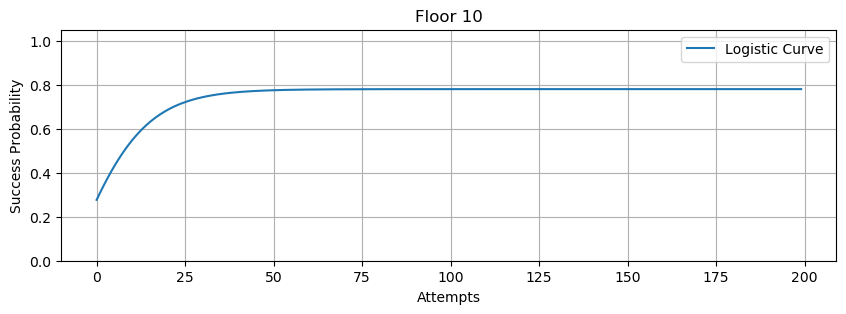

low=-0.77, high=0.78, shift=-7.32, speed=0.10


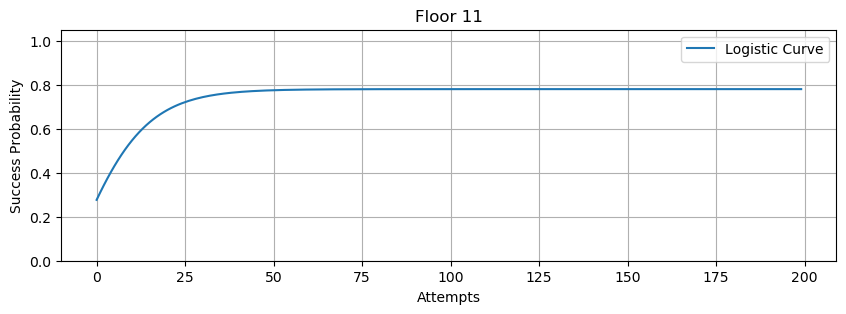

low=-0.77, high=0.78, shift=-7.32, speed=0.10


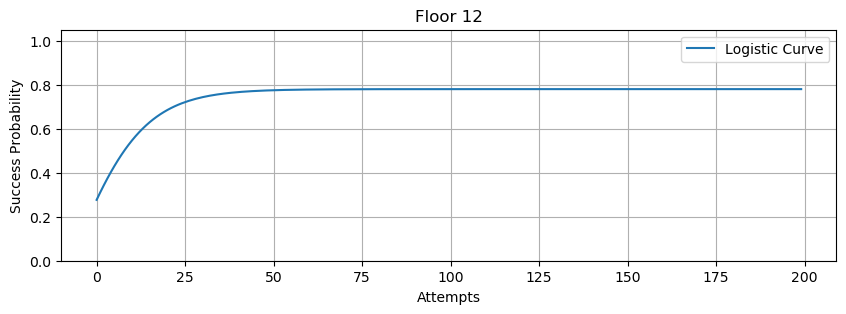

low=-0.77, high=0.78, shift=-7.32, speed=0.10


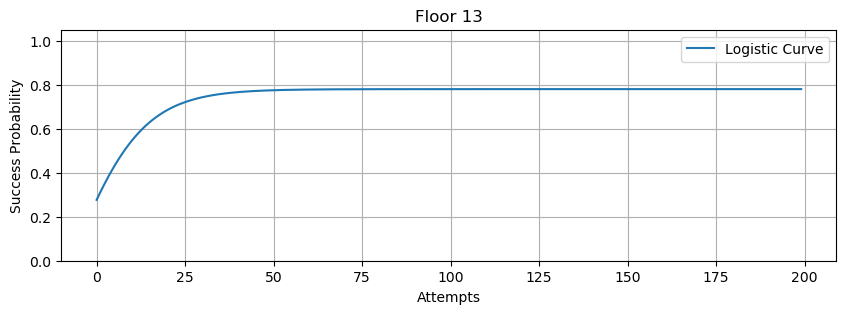

low=-0.77, high=0.78, shift=-7.32, speed=0.10


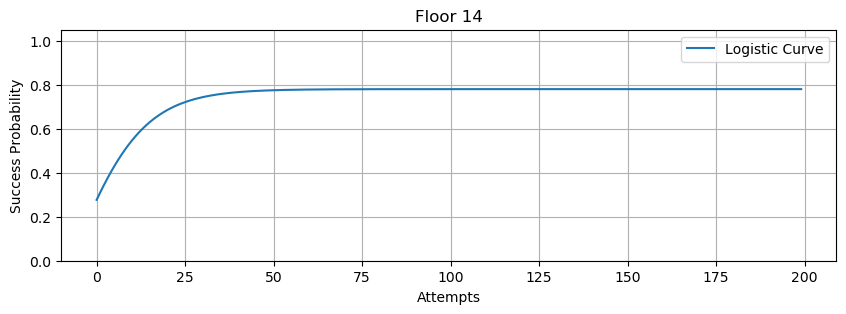

low=-0.77, high=0.78, shift=-7.32, speed=0.10


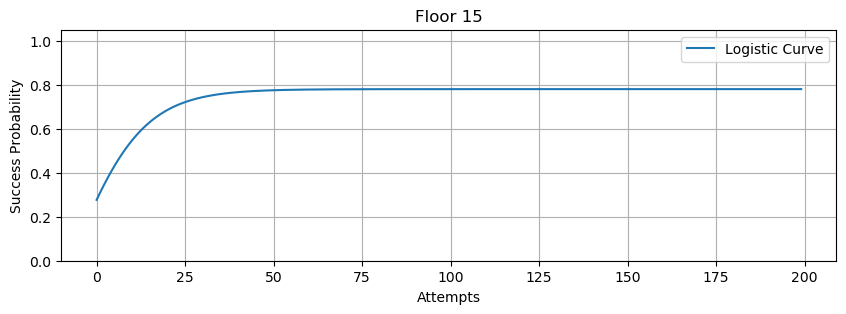

low=-0.77, high=0.78, shift=-7.32, speed=0.10


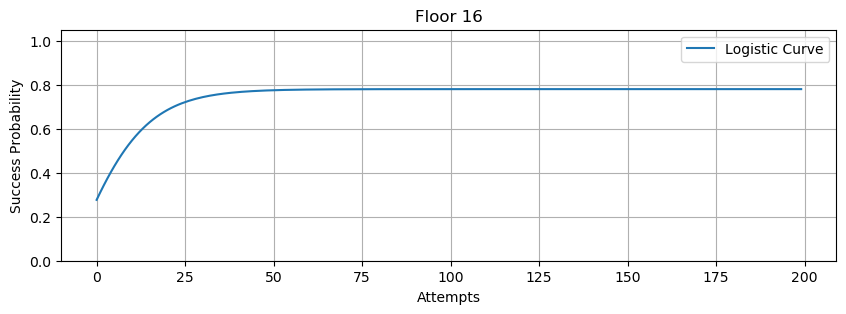

low=-0.77, high=0.78, shift=-7.32, speed=0.10


In [31]:
floors = []
for i in range(10):
    floors.append(Floor.from_data(wirtual_flat, i))
    
for i in range(10, 17):
    floors.append(Floor.from_params(i, -0.77, 0.78, -7.32, 0.1))
    
for floor in floors:
    floor.plot()
    print(f"low={floor.params[0]:.2f}, high={floor.params[1]:.2f}, shift={floor.params[2]:.2f}, speed={floor.params[3]:.2f}")

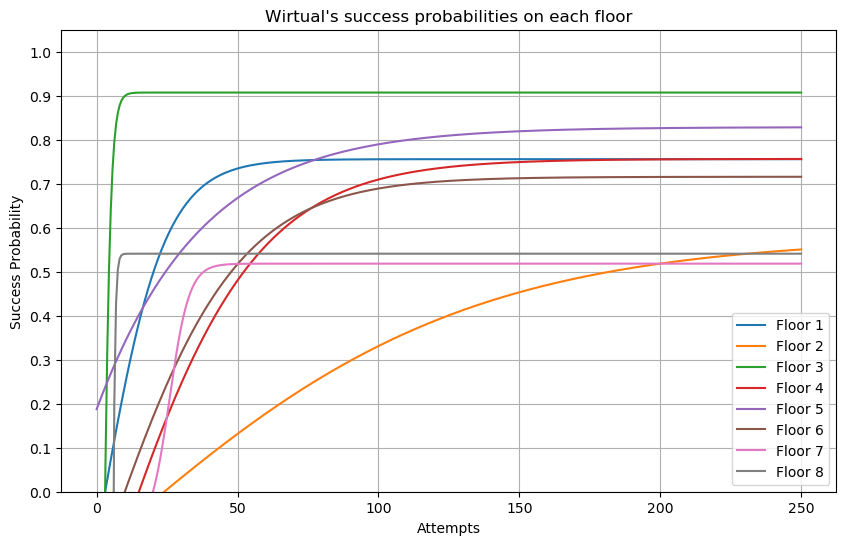

In [25]:
# Plot all floor probabilities in one plot
from matplotlib.ticker import MultipleLocator
x_values = np.linspace(0, 250, 400)
plt.figure(figsize=(10, 6))
plt.title(f'Wirtual\'s success probabilities on each floor')
plt.xlabel('Attempts')
plt.ylabel('Success Probability')
# Set the y-axis major ticks locator to be at intervals of 0.1
y_major_locator = MultipleLocator(0.1)
plt.gca().yaxis.set_major_locator(y_major_locator)
plt.ylim(0, 1.05)
plt.grid(True)
for floor in floors[1:9]:
    # Calculate y values
    low, high, shift, speed = floor.params
    y_values = logistic_curve(x_values, low, high, shift, speed)
    plt.plot(x_values, y_values, label=f'Floor {floor.floor}')
plt.legend()
plt.show()

In [6]:
prod = 1.0
for i in range(17):
    prod *= floors[i].params[1]
    print(f"Assuming enough practice, the chance to go through to floor {i+1} without fall: {prod}")

Assuming enough practice, the chance to go through to floor 1 without fall: 0.912711061897423
Assuming enough practice, the chance to go through to floor 2 without fall: 0.6743991895689125
Assuming enough practice, the chance to go through to floor 3 without fall: 0.38472979051279577
Assuming enough practice, the chance to go through to floor 4 without fall: 0.34111907922108503
Assuming enough practice, the chance to go through to floor 5 without fall: 0.2460141419606523
Assuming enough practice, the chance to go through to floor 6 without fall: 0.19610669661577357
Assuming enough practice, the chance to go through to floor 7 without fall: 0.13576842617885984
Assuming enough practice, the chance to go through to floor 8 without fall: 0.06959390097337065
Assuming enough practice, the chance to go through to floor 9 without fall: 0.03550125630198317
Assuming enough practice, the chance to go through to floor 10 without fall: 0.01307932547989519
Assuming enough practice, the chance to go 

In [32]:
results = []
for sim in range(1000):
    attempts = {i:0 for i in range(17)}
    first_time_reached_floor = [0]
    highest_reached_floor = 0
    current_floor = 0
    counter = 0
    while current_floor < 17:
        attempt_number = attempts[current_floor]
        new_floor = floors[current_floor].simulate_one_step(attempt_number)
        attempts[current_floor] += 1
        current_floor = new_floor
        counter += 1
        if current_floor > highest_reached_floor:
            highest_reached_floor = current_floor
            first_time_reached_floor.append(counter)
    results.append(first_time_reached_floor)
    if sim % 100 == 0:
        print(f"Simulations done: {sim}")

Simulations done: 0
Simulations done: 100
Simulations done: 200
Simulations done: 300
Simulations done: 400
Simulations done: 500
Simulations done: 600
Simulations done: 700
Simulations done: 800
Simulations done: 900


FLOOR 1
Minimum number of steps: 1 (0 hours)
Mean number of steps: 1 (0 hours)
Maximum number of steps: 1 (0 hours)
Standard deviation: 0 (0 hours)
Actually first time reached: 0 hours


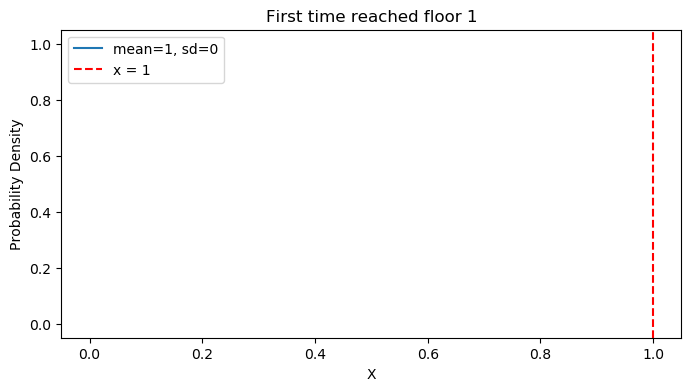

FLOOR 2
Minimum number of steps: 10 (0 hours)
Mean number of steps: 21 (1 hours)
Maximum number of steps: 40 (1 hours)
Standard deviation: 6 (0 hours)
Actually first time reached: 1 hours


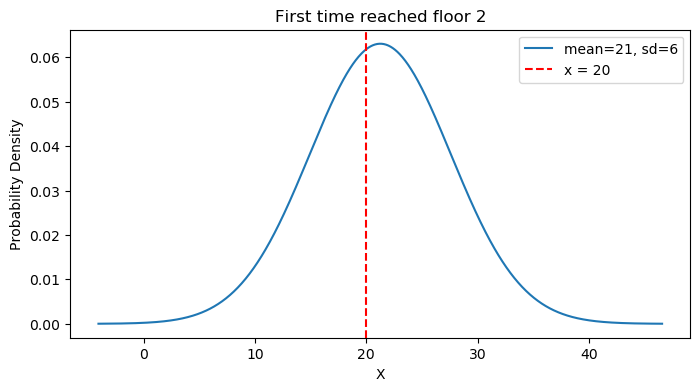

FLOOR 3
Minimum number of steps: 108 (4 hours)
Mean number of steps: 184 (6 hours)
Maximum number of steps: 304 (10 hours)
Standard deviation: 33 (1 hours)
Actually first time reached: 6 hours


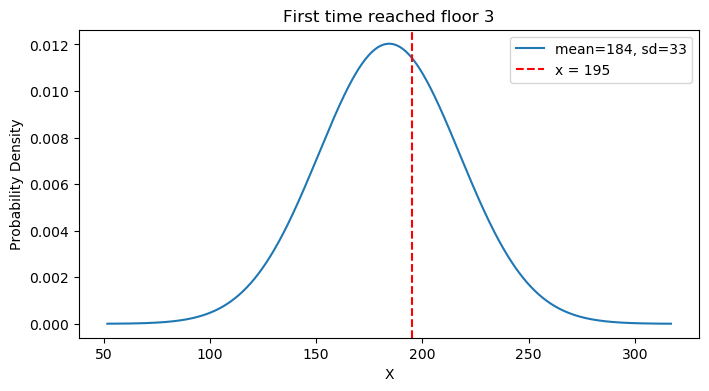

FLOOR 4
Minimum number of steps: 191 (6 hours)
Mean number of steps: 296 (10 hours)
Maximum number of steps: 424 (14 hours)
Standard deviation: 40 (1 hours)
Actually first time reached: 8 hours


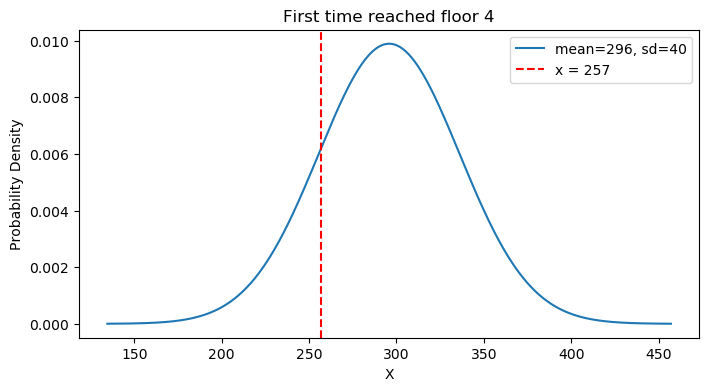

FLOOR 5
Minimum number of steps: 365 (12 hours)
Mean number of steps: 539 (18 hours)
Maximum number of steps: 760 (25 hours)
Standard deviation: 63 (2 hours)
Actually first time reached: 18 hours


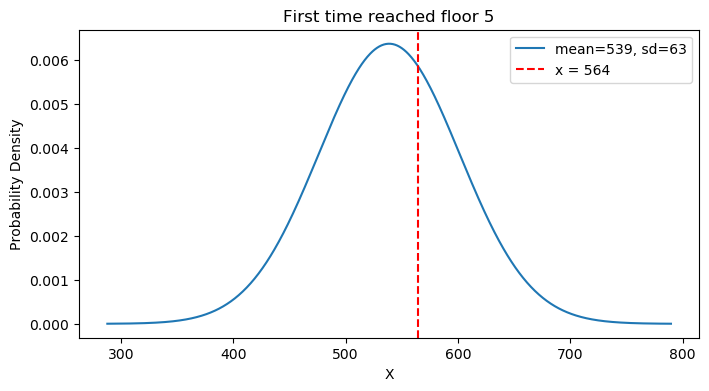

FLOOR 6
Minimum number of steps: 395 (13 hours)
Mean number of steps: 637 (21 hours)
Maximum number of steps: 988 (32 hours)
Standard deviation: 97 (3 hours)
Actually first time reached: 20 hours


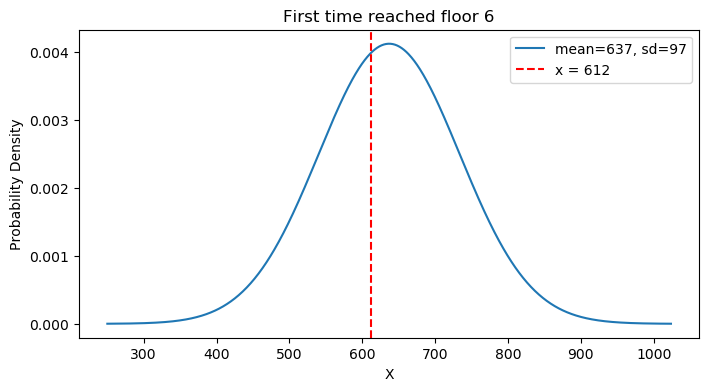

FLOOR 7
Minimum number of steps: 818 (27 hours)
Mean number of steps: 1172 (38 hours)
Maximum number of steps: 1570 (51 hours)
Standard deviation: 123 (4 hours)
Actually first time reached: 36 hours


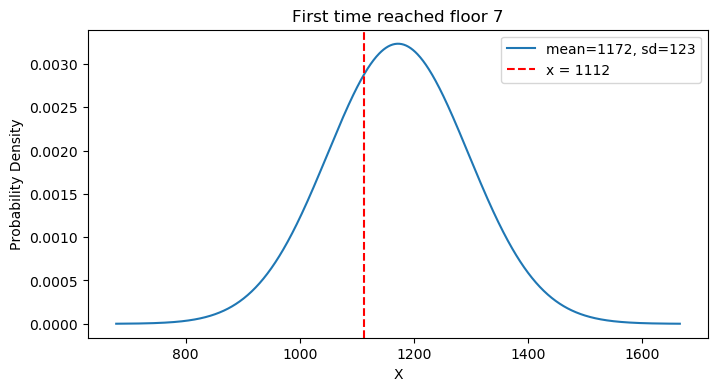

FLOOR 8
Minimum number of steps: 1476 (48 hours)
Mean number of steps: 1853 (61 hours)
Maximum number of steps: 2325 (76 hours)
Standard deviation: 142 (5 hours)
Actually first time reached: 58 hours


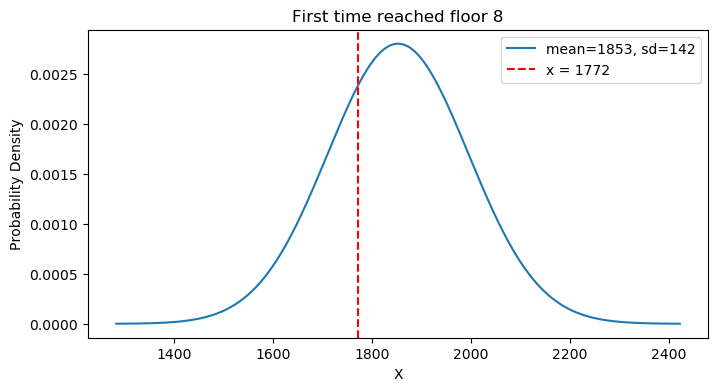

FLOOR 9
Minimum number of steps: 1726 (56 hours)
Mean number of steps: 2160 (71 hours)
Maximum number of steps: 2785 (91 hours)
Standard deviation: 164 (5 hours)
Actually first time reached: 69 hours


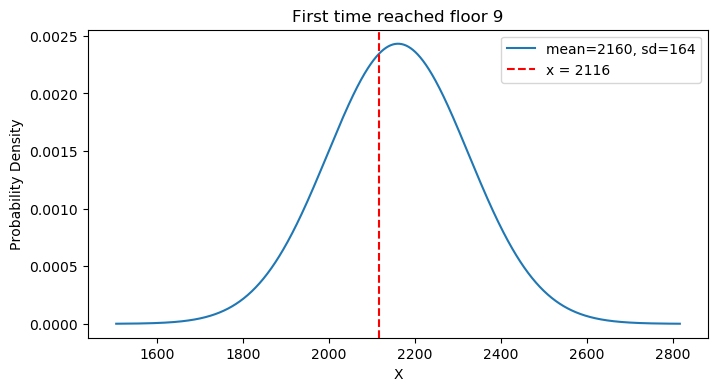

FLOOR 10
Minimum number of steps: 1846 (60 hours)
Mean number of steps: 2345 (77 hours)
Maximum number of steps: 3071 (100 hours)
Standard deviation: 207 (7 hours)
Actually first time reached: 77 hours


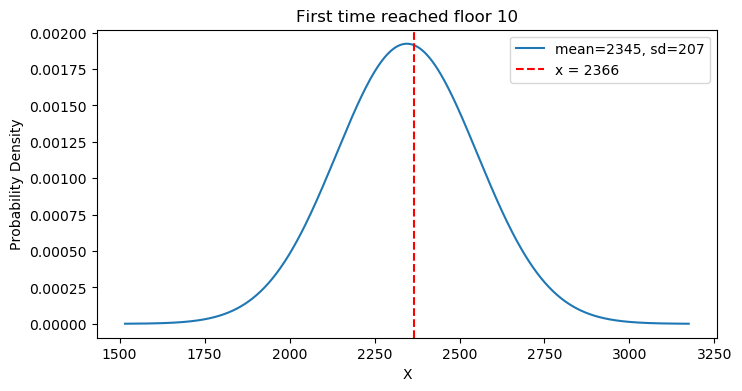

FLOOR 11
Minimum number of steps: 1847 (60 hours)
Mean number of steps: 2541 (83 hours)
Maximum number of steps: 4212 (138 hours)
Standard deviation: 326 (11 hours)
Actually first time reached: 87 hours


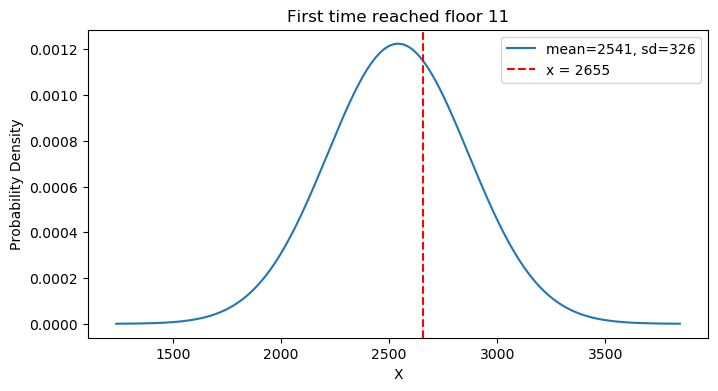

FLOOR 12
Minimum number of steps: 1922 (63 hours)
Mean number of steps: 2913 (95 hours)
Maximum number of steps: 5365 (175 hours)
Standard deviation: 547 (18 hours)


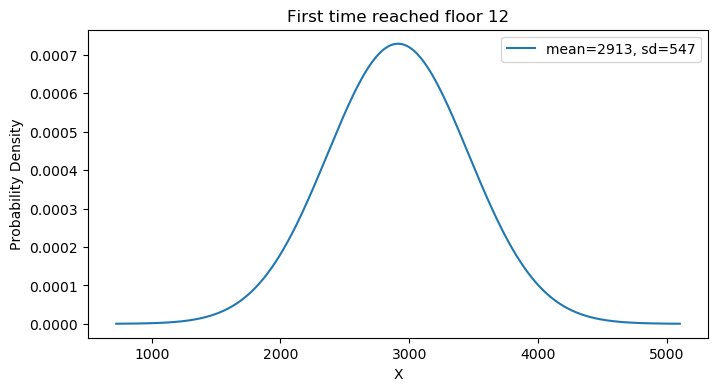

FLOOR 13
Minimum number of steps: 1957 (64 hours)
Mean number of steps: 3539 (116 hours)
Maximum number of steps: 6737 (220 hours)
Standard deviation: 804 (26 hours)


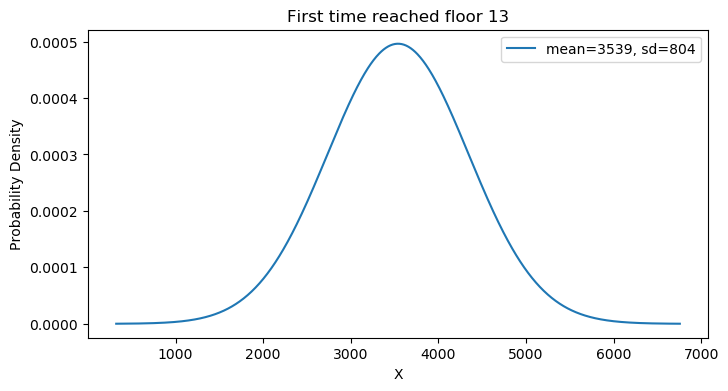

FLOOR 14
Minimum number of steps: 1958 (64 hours)
Mean number of steps: 4437 (145 hours)
Maximum number of steps: 9053 (296 hours)
Standard deviation: 1139 (37 hours)


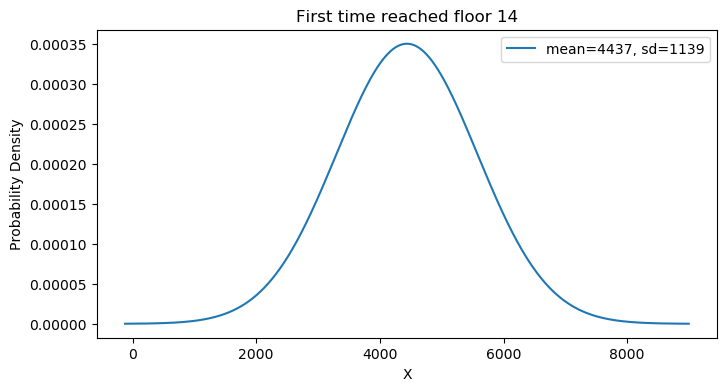

FLOOR 15
Minimum number of steps: 2238 (73 hours)
Mean number of steps: 5623 (184 hours)
Maximum number of steps: 11098 (363 hours)
Standard deviation: 1483 (48 hours)


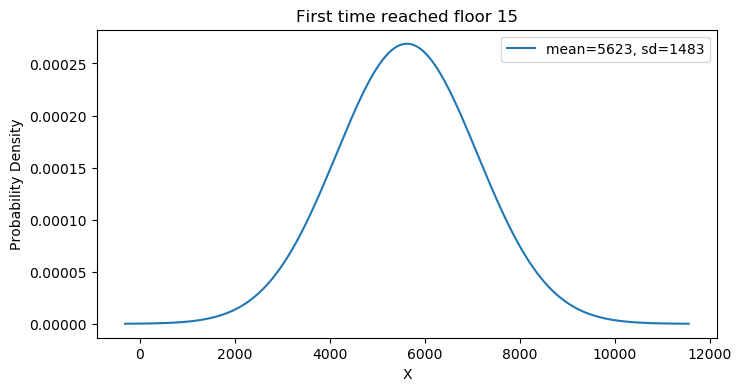

FLOOR 16
Minimum number of steps: 2340 (76 hours)
Mean number of steps: 7076 (231 hours)
Maximum number of steps: 13321 (435 hours)
Standard deviation: 1842 (60 hours)


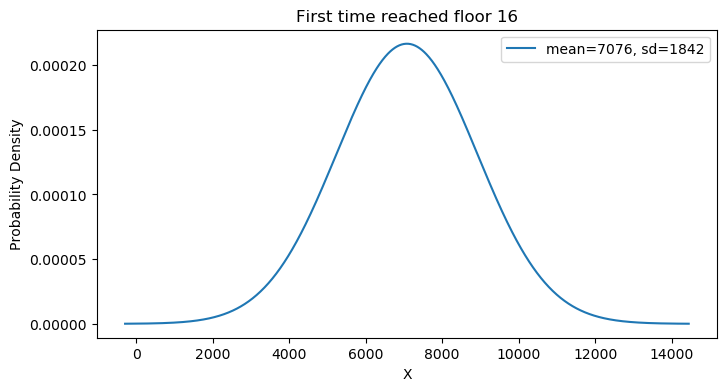

FLOOR 17
Minimum number of steps: 2703 (88 hours)
Mean number of steps: 8907 (291 hours)
Maximum number of steps: 17844 (583 hours)
Standard deviation: 2406 (79 hours)


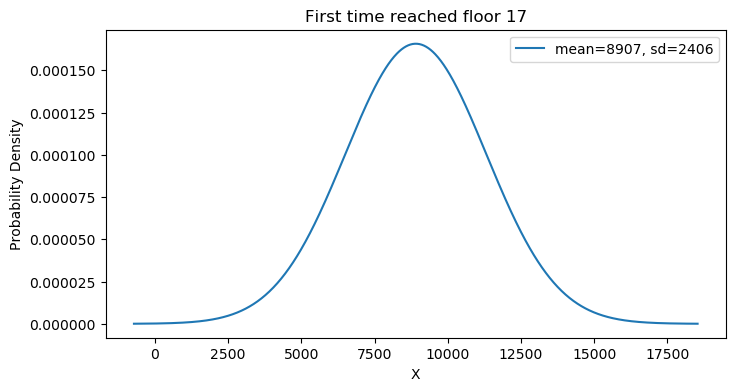

In [33]:
def gauss(mean, sd, title=None, highlight=None):
    x_values = np.linspace(mean - 4*sd, mean + 4*sd, 1000)
    y_values = norm.pdf(x_values, mean, sd)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, y_values, label=f'mean={mean:.0f}, sd={sd:.0f}')
    if highlight is not None:
        plt.axvline(x=highlight, color='r', linestyle='--', label=f'x = {highlight}')

    # Adding labels and title
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()

    # Display the plot
    plt.show()

steps_per_hour = len(wirtual_flat) / len(wirtual)
for f in range(1, 18):
    reached_floor = [sim[f] for sim in results]
    mean_steps = np.mean(reached_floor)
    min_steps = np.min(reached_floor)
    max_steps = np.max(reached_floor)
    sd_steps = np.std(reached_floor)
    print(f"FLOOR {f}")
    print(f"Minimum number of steps: {min_steps:.0f} ({min_steps / steps_per_hour:.0f} hours)")
    print(f"Mean number of steps: {mean_steps:.0f} ({mean_steps / steps_per_hour:.0f} hours)")
    print(f"Maximum number of steps: {max_steps:.0f} ({max_steps / steps_per_hour:.0f} hours)")
    print(f"Standard deviation: {sd_steps:.0f} ({sd_steps / steps_per_hour:.0f} hours)")
    if f < len(wirtual_first_time_reached_floor):
        print(f"Actually first time reached: {wirtual_first_time_reached_floor[f] / steps_per_hour:.0f} hours")
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}", highlight=wirtual_first_time_reached_floor[f])
    else:
        gauss(mean_steps, sd_steps, title=f"First time reached floor {f}")

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Example sequence of ones and zeros
attempts = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
successes = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1])

# Reshape attempts to be a 2D array with one column (as expected by scikit-learn)
X = attempts.reshape(-1, 1)
y = successes

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predict the probability of success for each attempt
y_prob = model.predict_proba(X)[:, 1]

# Predict the class for each attempt
y_pred = model.predict(X)

print("Predicted probabilities of success for each attempt:")
print(y_prob)

print("Predicted classes for each attempt:")
print(y_pred)



ModuleNotFoundError: No module named 'sklearn'